# Molecular docking via DC-QAOA

The data of the clique graph for the molecular docking are taken from this [paper](https://arxiv.org/pdf/2308.04098)

In [29]:
import cudaq
from cudaq import spin
import numpy as np


cudaq.set_target('nvidia')

In [30]:
# The two graphs input from the paper

# BIG 1

nodes=[0,1,2,3,4,5]
qubit_num=len(nodes)
edges= [[0,1],[0,2],[0,4],[0,5],[1,2],[1,3],[1,5],[2,3],[2,4],[3,4],[3,5],[4,5]]
non_edges=[[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
print('Edges: ', edges)
print('Non-Edges: ', non_edges)
weights=[0.6686,0.6686,0.6686,0.1453,0.1453,0.1453]
penalty=6.0
num_layers=3

# BIG 2 (More expensive simulation)

#nodes=[0,1,2,3,4,5,6,7]
#qubit_num=len(nodes)
#edges=[[0,1],[0,2],[0,5],[0,6],[0,7],[1,2],[1,4],[1,6],[1,7],[2,4],[2,5],[2,7],[3,4],[3,5],[3,6],\
#    [4,5],[4,6],[5,6]]
#non_edges=[[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
#print('Edges: ', edges)
#print('Non-edges: ', non_edges)
#weights=[0.6686,0.6686,0.6886,0.1091,0.0770,0.0770,0.0770,0.0770]
#penalty=8.0
#num_layers=8

Edges:  [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 5]]
Non-Edges:  [[0, 3], [1, 4], [2, 5]]


In [31]:
# Generate the Hamiltonian
def ham_clique(penalty, nodes, weights, non_edges)-> cudaq.SpinOperator:
    
    spin_ham=0.0
    for wt,node in zip(weights,nodes):
        #print(wt,node)
        spin_ham+=0.5*wt*spin.z(node)
        spin_ham-=0.5*wt*spin.i(node)
    
    for non_edge in non_edges:
        u,v=(non_edge[0],non_edge[1])
        #print(u,v)
        spin_ham+=penalty/4.0*(spin.z(u)*spin.z(v)-spin.z(u)-spin.z(v)+spin.i(u)*spin.i(v))
    
    return spin_ham   

In [32]:
# Collect coefficients from a spin operator so we can pass them to a kernel
def term_coefficients(ham: cudaq.SpinOperator) -> list[complex]:
    result = []
    ham.for_each_term(lambda term: result.append(term.get_coefficient()))
    return result

    # Collect Pauli words from a spin operator so we can pass them to a kernel
def term_words(ham: cudaq.SpinOperator) -> list[str]:
    result = []
    ham.for_each_term(lambda term: result.append(term.to_string(False)))
    return result
    

In [33]:
@cudaq.kernel
def dc_qaoa(qubit_num:int, num_layers:int,thetas:list[float],\
    coef:list[complex], words:list[cudaq.pauli_word]):
    
    qubits=cudaq.qvector(qubit_num)
    
    h(qubits)
    
    count=0
    for p in range(num_layers):
        
        for i in range(len(coef)):
            exp_pauli(thetas[count]*coef[i].real,qubits,words[i])
            count+=1
        
        for j in range(qubit_num):
            rx(thetas[count],qubits[j])
            count+=1 
        
        for k in range(qubit_num):
            ry(thetas[count],qubits[k])
            count+=1

In [34]:
ham= ham_clique(penalty,nodes,weights,non_edges)
print(ham)

coef=term_coefficients(ham)
words=term_words(ham)

print(term_coefficients(ham))
print(term_words(ham))

[1.5+0j] IIZIIZ
[1.5+0j] ZIIZII
[-1.1657+0j] IZIIII
[1.5+0j] IZIIZI
[-1.42735+0j] IIIZII
[3.2791499999999996+0j] IIIIII
[-1.1657+0j] IIZIII
[-1.42735+0j] IIIIIZ
[-1.1657+0j] ZIIIII
[-1.42735+0j] IIIIZI

[(1.5+0j), (1.5+0j), (-1.1657+0j), (1.5+0j), (-1.42735+0j), (3.2791499999999996+0j), (-1.1657+0j), (-1.42735+0j), (-1.1657+0j), (-1.42735+0j)]
['IIZIIZ', 'ZIIZII', 'IZIIII', 'IZIIZI', 'IIIZII', 'IIIIII', 'IIZIII', 'IIIIIZ', 'ZIIIII', 'IIIIZI']


In [35]:
# Optimizer

# Specify the optimizer and its initial parameters.
optimizer = cudaq.optimizers.NelderMead()
#optimizer = cudaq.optimizers.COBYLA()

np.random.seed(13)
cudaq.set_random_seed(13)

# if dc_qaoa used
parameter_count=(2*qubit_num+len(coef))*num_layers

# if qaoa used
# parameter_count=(qubit_num+len(coef))*num_layers

print('Total number of parameters: ', parameter_count)
optimizer.initial_parameters = np.random.uniform(-np.pi/8 , np.pi/8 ,parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Total number of parameters:  66
Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064, 0.37118004688049144, -0.03656087558321203, 0.08564174998504231, 0.21639801853794682, 0.11122286088634259, 0.1743727097033635, -0.36518146001762486, -0.15829741539542244, -0.3467434780387345, 0.28043500852894776, -0.09986021299050934, 0.14125225086023052, -0.19141728018199775, -0.11970943368650361, -0.3853063093646483, -0.1112643868789806, 0.3527177454825464, -0.22156160012057186, -0.1418496891385843, 0.32811766468303116, -0.367642000671186, -0.34158180583996006, 0.10196745745501312, 0.29359239180502594, -0.3858537615546677, 0.19366130907065582, 0.24570488114056754, -0.3332307385378807, 0.12287973244618389, 0.007274514934614895, -0.015799547372526146, 0.3578070967202224, -0.39268963055535144, -0.19872246354138554, 0.16668715544467982, -0.13777293592446055, -0.17514665212709513, 0.15350249947988204, 0.32872977428061945, -0.20068831419712105, -0.0329193

In [8]:
cost_values=[]
def objective(parameters):

    cost=cudaq.observe(dc_qaoa, ham, qubit_num, num_layers, parameters,coef,words).expectation()
    cost_values.append(cost)
    return cost

# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)

optimal_expectation = -2.0057493966746804
optimal_parameters = [2.0508763934174787, 0.013930789730781493, 0.5793211220774144, 0.878009560684498, 0.5277129177248182, 0.4404810513078178, 0.5755552245467919, 0.14125558672355468, 0.3724262117066903, 0.1318978057007808, -1.1228708513911436, 0.932342804955409, -0.8478237950658537, 0.46345886313018125, -0.5809397306340341, 0.2408342488137229, 0.11216088888484882, -0.009704173265255175, 0.4757346661223584, -0.7281211610985926, 0.06051951319169091, -0.7794512146826196, 0.09249435261907034, 0.09998378319110682, 1.255349350720572, 1.2607038244228248, 0.2060124032311757, 0.13991934581192997, 0.9874814082082164, -0.1591291464755939, 0.30815482837046393, -0.9701804681517978, -0.002609462845755913, 0.43533533568363353, 0.642630110681613, 0.6137063363954748, -0.7204687246344496, 0.08390768435524378, 0.5480630700433249, -0.38905723227347905, -0.6837811162838194, -0.17239016898719284, 0.1649341118754853, -0.46771209183422724, -0.008565327035838663, 1.98

In [10]:
shots=200000

counts = cudaq.sample(dc_qaoa, qubit_num, num_layers, optimal_parameters,coef,words, shots_count=shots)
print(counts)

print('The MVWCP is given by the partition: ', max(counts, key=lambda x: counts[x]))

# Alternative
print('The MVWCP is given by the partition: ', counts.most_probable())

{ 110001:10 011100:2 111000:199986 011000:2 }

The MVWCP is given by the partition:  111000
The MVWCP is given by the partition:  111000


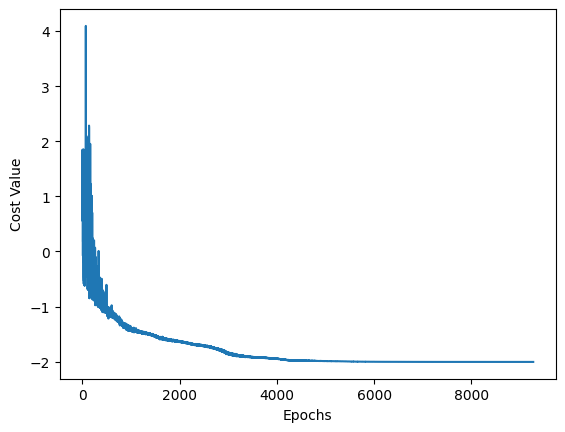

In [11]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.show()